# 🔊 Working with Audio in Python

<img src="https://miro.medium.com/max/1100/1*Zx9QAMPzxhama9O4q9xWXg.jpeg" width="600"/>

This notebook is intended to be an introduction for anyone interested in using python to interperate audio data.

Please watch the youtube video that discusses the contents of this notebook if you want to learn more!
- [Video Link](https://www.youtube.com/watch?v=ZqpSb5p1xQo)
- [Youtube Channel](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Terms to know for Audio in Digital Form:

## Frequency (Hz)
- Frequency describes the differences of wave lengths.
- We interperate frequency has high and low pitches.

<img src="https://uploads-cdn.omnicalculator.com/images/britannica-wave-frequency.jpg" width="400"/>

## Intensity (db / power)
- Intensity describes the amplitude (height) of the wave.

<img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780124722804500162-f13-15-9780124722804.gif" width="400"/>

## Sample Rate
- Sample rate is specific to how the computer reads in the audio file.
- Think of it as the "resolution" of the audio.

<img src="https://www.headphonesty.com/wp-content/uploads/2019/07/Sample-Rate-Bit-Depth-and-Bit-Rate.jpeg" width="400"/>


# Reading in Audio Files
There are many types of audio files: `mp3`, `wav`, `m4a`, `flac`, `ogg`

In [2]:
audio_files = glob('UrbanSound8K/audio/fold1/*.wav')

In [3]:
# Play audio file
ipd.Audio(audio_files[0])

KeyboardInterrupt: 

In [ ]:
y, sr = librosa.load(audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00011485 -0.00017083 -0.00017736 -0.00016102 -0.00013866 -0.00017711
 -0.00015624 -0.00027277 -0.00022342 -0.00023939]
shape y: (88200,)
sr: 22050


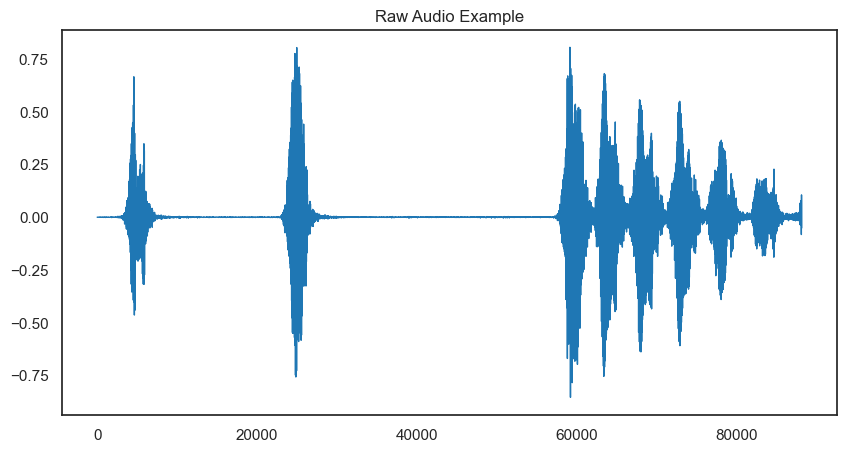

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

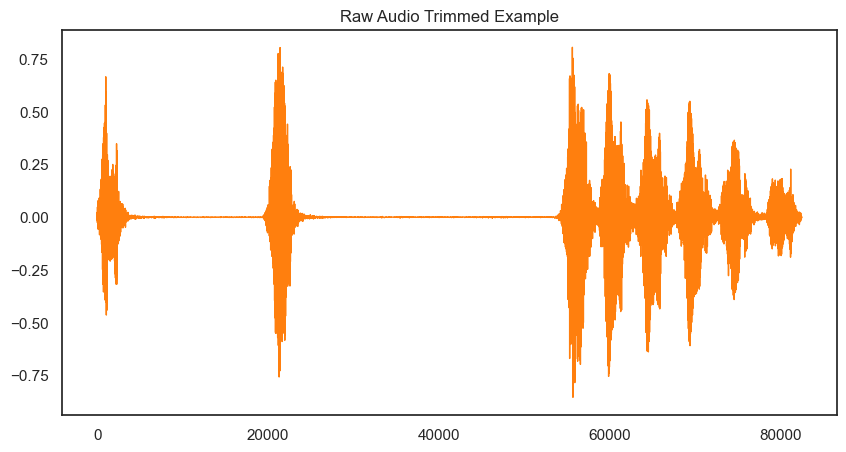

In [ ]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=20)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

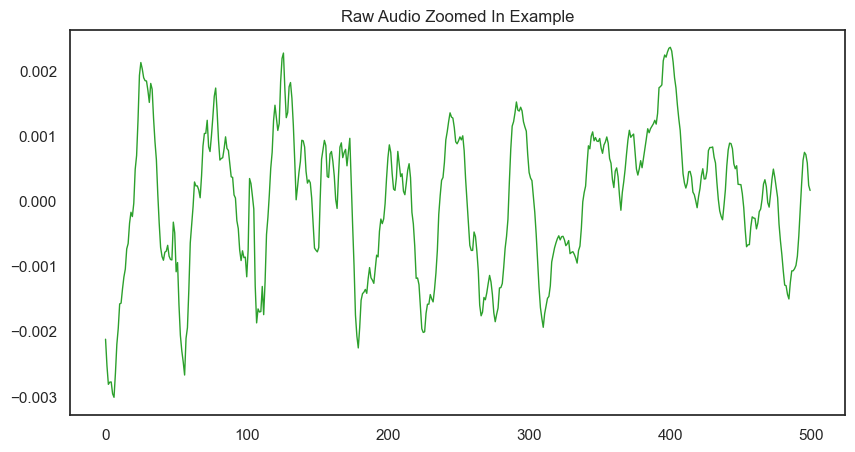

In [ ]:
pd.Series(y[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

# Spectogram

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 173)

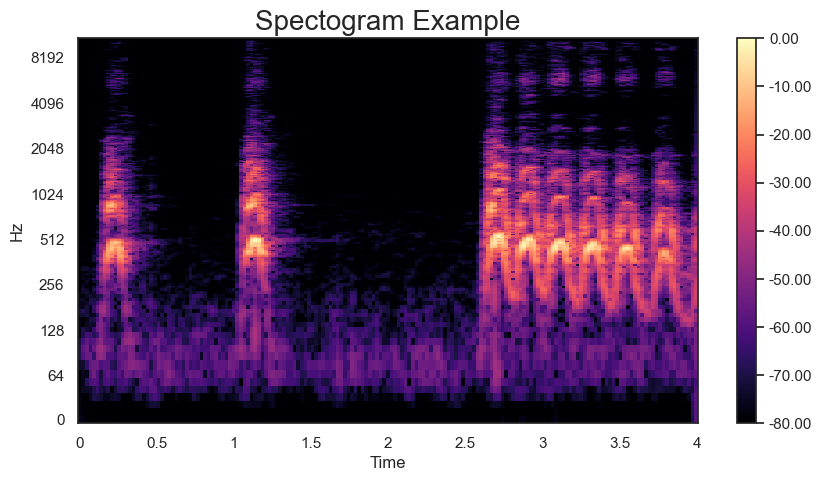

In [ ]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Mel Spectogram

In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=512,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

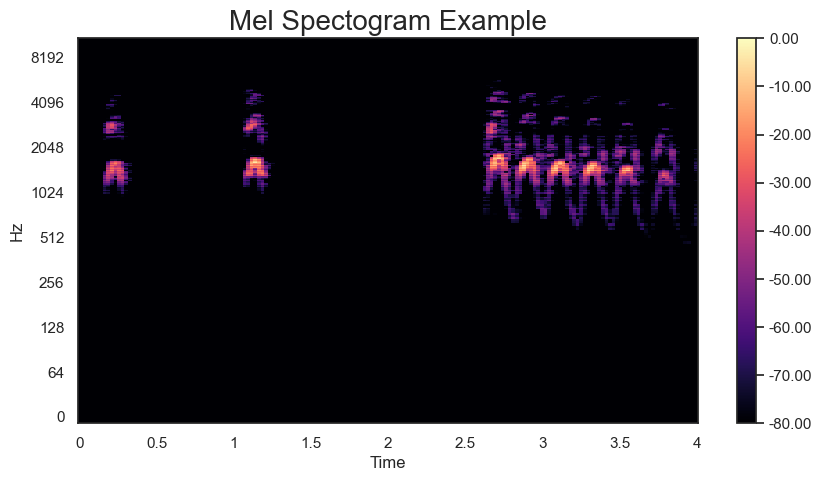

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [2]:
import glob
import os
import librosa
import numpy as np
from librosa.feature import melspectrogram

def LOG_MEL_SPEC(parent_dir, sub_dir):
    labels = []
    log_mel_spectrogram = []
    exten = "*.wav"
    
    for filename in glob.glob(os.path.join(parent_dir, sub_dir, exten)):
        # Extract label from filename - assuming the class name is embedded in the filename
        label = filename.split('fold')[1].split('-')[1]  # Adjust this as necessary for the filename format
        labels.append(int(label))  # Convert label to integer
        f, sr = librosa.load(filename, sr=16000)  # Load audio file with 16kHz sample rate
        
        # Define target duration (4 seconds)
        four_sec_samples = 4 * sr
        if len(f) >= four_sec_samples:
            # Take first 4 seconds if the audio is long enough
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        else:
            # Pad audio to 4 seconds if it's shorter
            while len(f) < four_sec_samples:
                f = np.concatenate((f, f))  # Repeat audio to pad
            log_mel_spec = librosa.power_to_db(
                melspectrogram(y=f[:four_sec_samples], sr=sr, n_fft=1024, hop_length=128)
            )
        
        log_mel_spectrogram.append(log_mel_spec)
    
    return np.array(log_mel_spectrogram), np.array(labels, dtype=int)

def encode(labels):
    # One hot encoding of labels
    labels_total = len(labels)
    unique_labels_total = len(np.unique(labels))
    one_hot_encoded = np.zeros((labels_total, unique_labels_total))
    one_hot_encoded[np.arange(labels_total), labels] = 1
    return one_hot_encoded

def file_creator(final_path, filename):
    new_path = os.path.join(os.getcwd(), final_path)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    return os.path.join(new_path, filename)

# Set the parent directory where UrbanSound8K data is stored
parent_directory = 'UrbanSound8K/audio'  # Adjust this path as needed
final_dir = "UrbanSound8K/UrbanSound8K_Processed"

# Process each fold and save the features and labels
sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

for sub_dir in sub_dirs:
    print(f"Processing {sub_dir}...")
    features, labels = LOG_MEL_SPEC(parent_directory, sub_dir)
    
    # One hot encode the labels
    labels_encoded = encode(labels)
    
    # Create filenames for saving features and labels
    feature_file = file_creator(final_dir, f'{sub_dir}_features.npy')
    labels_file = file_creator(final_dir, f'{sub_dir}_labels.npy')
    
    # Save the extracted features and labels
    np.save(feature_file, features)
    print(f"Saved features for {sub_dir} at {feature_file}")
    np.save(labels_file, labels_encoded)
    print(f"Saved labels for {sub_dir} at {labels_file}")


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the features and labels for each fold
processed_dir = 'UrbanSound8K/UrbanSound8K_Processed'

# Specify folds
folds = [f'fold{i}' for i in range(1, 11)]  # Folds 1 to 10

# Assign test, validation, and training folds dynamically
test_fold = folds[9]  # Use fold 8 for testing (index 7)
validation_fold = folds[8]  # Use fold 9 for validation (index 8)
train_folds = [fold for fold in folds if fold not in [test_fold, validation_fold]]  # Remaining for training

# Debugging: Print the fold assignments
print(f"Training folds: {train_folds}")
print(f"Validation fold: {validation_fold}")
print(f"Test fold: {test_fold}")


def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)

# Load training, validation, and test data
X_train, y_train = load_data(train_folds, processed_dir)
X_val, y_val = load_data([validation_fold], processed_dir)
X_test, y_test = load_data([test_fold], processed_dir)

# Reshape features for CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Ensure labels are one-hot encoded
num_classes = 10
y_train = np.reshape(y_train, (-1, num_classes))
y_val = np.reshape(y_val, (-1, num_classes))
y_test = np.reshape(y_test, (-1, num_classes))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")




model = models.Sequential([
    layers.InputLayer(input_shape=(128, 251, 1)),  # Input shape matches your data
    
    # Example of convolutional layers with 'same' padding
    layers.Conv2D(32, (3, 3), activation='tanh'),  # 'same' padding keeps dimensions
    layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling reduces dimensions

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Pooling further reduces dimensions

    # Example of a smaller pool size to prevent dimension collapse
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),  # More pooling layers

    # Flatten and output layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # Adjust to match the number of classes in your dataset
])

model.summary()




# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)



def generate_noisy_examples(X, y, model, noise_factor=0.1, ratio=0.05):
    """
    Generate a limited number of noisy examples for misclassified samples.
    Args:
        X: Input validation data.
        y: True labels for validation data.
        model: Trained model for prediction.
        noise_factor: The magnitude of noise to add.
        ratio: Proportion of noisy samples to generate relative to misclassifications (e.g., 0.1 for 1:10).
    Returns:
        X_noisy: Generated noisy samples.
        y_noisy: Corresponding labels for noisy samples.
    """
    # Predict on the validation data
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y, axis=1)
    
    # Identify misclassified samples
    misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]
        # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    print(f"Total misclassified: {len(misclassified_indices)}, Ratio: {ratio}, Noisy samples to generate: {num_noisy_samples}")

    
    # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    selected_indices = np.random.choice(misclassified_indices, size=num_noisy_samples, replace=False)
    
    X_noisy = []
    y_noisy = []
    
    for idx in selected_indices:
        # Add Gaussian noise to the misclassified sample
        noise = noise_factor * np.random.normal(size=X[idx].shape)
        noisy_sample = np.clip(X[idx] + noise, 0, 1)  # Ensure values are within range
        X_noisy.append(noisy_sample)
        y_noisy.append(y[idx])  # Use the correct label
    
    return np.array(X_noisy), np.array(y_noisy)

# Training with noisy examples between epochs

history = []  # To store history across all epochs
max_epochs = 50
patience_limit = 6  # To check for manual early stopping (optional)

# Initialize counters and flags
early_stop_counter = 0
best_val_loss = float('inf')  # Start with a very high value

best_weights = None  # Initialize variable to store the best weights

for epoch in range(1, max_epochs + 1):
    print(f"Epoch {epoch}/{max_epochs}")

    # Train model for one epoch
    hist = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store history
    history.append(hist.history)

    # Extract validation loss for manual early stopping check
    val_loss = hist.history.get('val_loss', [None])[-1]
    if val_loss is not None:
        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save best weights
            early_stop_counter = 0  # Reset counter if there's improvement
        else:
            early_stop_counter += 1  # Increment counter if no improvement

    # Check for early stopping (manual or callback-based)
    if early_stop_counter >= patience_limit:
        print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
        model.set_weights(best_weights)  # Restore the best weights
        break

    # Generate noisy examples based on validation performance
    X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.05)

    # Inject noisy examples back into training
    if len(X_noisy) > 0:
        X_train = np.concatenate([X_train, X_noisy])
        y_train = np.concatenate([y_train, y_noisy])
        print(f"Added {len(X_noisy)} noisy examples to the training set.")



# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Training folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8']
Validation fold: fold9
Test fold: fold10
X_train shape: (7079, 128, 251, 1), y_train shape: (7079, 10)
X_val shape: (816, 128, 251, 1), y_val shape: (816, 10)
X_test shape: (837, 128, 251, 1), y_test shape: (837, 10)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 126, 249, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 61, 122, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 59, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,090 (461.29 KB)

 Trainable params: 118,090 (461.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 434ms/step - accuracy: 0.1966 - loss: 2.1352 - val_accuracy: 0.3358 - val_loss: 1.7150 - learning_rate: 0.0010
Validation Loss: 1.7150
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
Total misclassified: 542, Ratio: 0.05, Noisy samples to generate: 27
Added 27 noisy examples to the training set.
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 429ms/step - accuracy: 0.4124 - loss: 1.6002 - val_accuracy: 0.3995 - val_loss: 1.6255 - learning_rate: 0.0010
Validation Loss: 1.6255
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
Total misclassified: 490, Ratio: 0.05, Noisy samples to generate: 24
Added 24 noisy examples to the training set.
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 439ms/step - accuracy: 0.4751 - loss: 1.4455 - val_accuracy: 0.4939 - val_loss: 1.5363 - learning_rate: 0.0010
Validation Loss: 1.5363
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Total misclassified: 413, Ratio: 0.05, Noisy samples to generate: 20
Added 20 noisy examples to the training set.
E

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the features and labels for each fold
processed_dir = 'UrbanSound8K/UrbanSound8K_Processed'

# Specify folds
folds = [f'fold{i}' for i in range(1, 11)]  # Folds 1 to 10

# Assign test, validation, and training folds dynamically
test_fold = folds[9]  # Use fold 8 for testing (index 7)
validation_fold = folds[8]  # Use fold 9 for validation (index 8)
train_folds = [fold for fold in folds if fold not in [test_fold, validation_fold]]  # Remaining for training

# Debugging: Print the fold assignments
print(f"Training folds: {train_folds}")
print(f"Validation fold: {validation_fold}")
print(f"Test fold: {test_fold}")


def load_data(folds, processed_dir):
    features_list, labels_list = [], []
    for fold in folds:
        features_file = f"{processed_dir}/{fold}_features.npy"
        labels_file = f"{processed_dir}/{fold}_labels.npy"
        features_list.append(np.load(features_file))
        labels_list.append(np.load(labels_file))
    return np.concatenate(features_list), np.concatenate(labels_list)

# Load training, validation, and test data
X_train, y_train = load_data(train_folds, processed_dir)
X_val, y_val = load_data([validation_fold], processed_dir)
X_test, y_test = load_data([test_fold], processed_dir)

# Reshape features for CNN input: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Ensure labels are one-hot encoded
num_classes = 10
y_train = np.reshape(y_train, (-1, num_classes))
y_val = np.reshape(y_val, (-1, num_classes))
y_test = np.reshape(y_test, (-1, num_classes))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten, Bidirectional


input_shape = (128,251)  # Shape do set de treino

model = Sequential()

# LSTM layers
model.add(LSTM(128, return_sequences=True, activation='tanh',input_shape=input_shape))
model.add(Bidirectional(LSTM(64, return_sequences=True, activation='tanh')))
model.add(MaxPooling1D())
# TimeDistributed Dense layers
model.add(TimeDistributed(Dense(256, activation='tanh')))
model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(256, activation='tanh')))
model.add(MaxPooling1D())
#model.add(Dropout(0.4))

#model.add(Dropout(0.4))
#model.add(TimeDistributed(Dense(8, activation='tanh', kernel_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.3))

# Pooling to reduce sequence
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layers
model.add(Dense(10, activation='softmax'))

model.summary()


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)



def generate_noisy_examples(X, y, model, noise_factor=0.1, ratio=0.1):
    """
    Generate a limited number of noisy examples for misclassified samples.
    Args:
        X: Input validation data.
        y: True labels for validation data.
        model: Trained model for prediction.
        noise_factor: The magnitude of noise to add.
        ratio: Proportion of noisy samples to generate relative to misclassifications (e.g., 0.1 for 1:10).
    Returns:
        X_noisy: Generated noisy samples.
        y_noisy: Corresponding labels for noisy samples.
    """
    # Predict on the validation data
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y, axis=1)
    
    # Identify misclassified samples
    misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]
        # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    print(f"Total misclassified: {len(misclassified_indices)}, Ratio: {ratio}, Noisy samples to generate: {num_noisy_samples}")

    
    # Determine the number of noisy samples to generate
    num_noisy_samples = max(1, int(len(misclassified_indices) * ratio))  # At least 1 sample
    selected_indices = np.random.choice(misclassified_indices, size=num_noisy_samples, replace=False)
    
    X_noisy = []
    y_noisy = []
    
    for idx in selected_indices:
        # Add Gaussian noise to the misclassified sample
        noise = noise_factor * np.random.normal(size=X[idx].shape)
        noisy_sample = np.clip(X[idx] + noise, 0, 1)  # Ensure values are within range
        X_noisy.append(noisy_sample)
        y_noisy.append(y[idx])  # Use the correct label
    
    return np.array(X_noisy), np.array(y_noisy)

# Training with noisy examples between epochs

history = []  # To store history across all epochs
max_epochs = 50
patience_limit = 5  # To check for manual early stopping (optional)

# Initialize counters and flags
early_stop_counter = 0
best_val_loss = float('inf')  # Start with a very high value

best_weights = None  # Initialize variable to store the best weights

for epoch in range(1, max_epochs + 1):
    print(f"Epoch {epoch}/{max_epochs}")

    # Train model for one epoch
    hist = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=1,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store history
    history.append(hist.history)

    # Extract validation loss for manual early stopping check
    val_loss = hist.history.get('val_loss', [None])[-1]
    if val_loss is not None:
        print(f"Validation Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()  # Save best weights
            early_stop_counter = 0  # Reset counter if there's improvement
        else:
            early_stop_counter += 1  # Increment counter if no improvement

    # Check for early stopping (manual or callback-based)
    if early_stop_counter >= patience_limit:
        print(f"Early stopping triggered after {epoch} epochs. Best val_loss: {best_val_loss:.4f}")
        model.set_weights(best_weights)  # Restore the best weights
        break

    # Generate noisy examples based on validation performance
    X_noisy, y_noisy = generate_noisy_examples(X_val, y_val, model, noise_factor=0.05, ratio=0.1)

    # Inject noisy examples back into training
    if len(X_noisy) > 0:
        X_train = np.concatenate([X_train, X_noisy])
        y_train = np.concatenate([y_train, y_noisy])
        print(f"Added {len(X_noisy)} noisy examples to the training set.")



# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Training folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8']
Validation fold: fold9
Test fold: fold10
X_train shape: (7079, 128, 251, 1), y_train shape: (7079, 10)
X_val shape: (816, 128, 251, 1), y_val shape: (816, 10)
X_test shape: (837, 128, 251, 1), y_test shape: (837, 10)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128, 128)       │       194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 64, 256)        │        33,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 64, 256)        │        65,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,449,802 (5.53 MB)

 Trainable params: 1,449,802 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.2123 - loss: 2.0913 - val_accuracy: 0.4461 - val_loss: 1.6077 - learning_rate: 5.0000e-04
Validation Loss: 1.6077
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
Total misclassified: 452, Ratio: 0.1, Noisy samples to generate: 45
Added 45 noisy examples to the training set.
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.4728 - loss: 1.5038 - val_accuracy: 0.5319 - val_loss: 1.4302 - learning_rate: 5.0000e-04
Validation Loss: 1.4302
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Total misclassified: 382, Ratio: 0.1, Noisy samples to generate: 38
Added 38 noisy examples to the training set.
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.5578 - loss: 1.2680 - val_accuracy: 0.5196 - val_loss: 1.4179 - learning_rate: 5.0000e-04
Validation Loss: 1.4179
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Total misclassified: 392, Ratio: 0.1, Noisy samples to generate: 39
Added 39 noisy examples to the traini

In [ ]:
import tensorflow as tf
import librosa
import pandas as pd
import numpy as np
import os

def preprocess_audio(file_path, target_sr=22050, n_mels=128, duration=4.0):
    # Load and preprocess audio
    y, sr = librosa.load(file_path, sr=target_sr)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    fixed_length = int(target_sr * duration)
    if len(y_trimmed) < fixed_length:
        y = np.pad(y_trimmed, (0, fixed_length - len(y_trimmed)), mode="constant")
    else:
        y = y_trimmed[:fixed_length]
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())  # Normalize
    return mel_spec_db.astype(np.float32)

def load_data(csv_path, audio_folder):
    df = pd.read_csv(csv_path)
    file_paths = [os.path.join(audio_folder, f"fold{row['fold']}", row['slice_file_name']) for _, row in df.iterrows()]
    labels = df['classID'].values
    return file_paths, labels

def data_generator(file_paths, labels, target_sr=22050, n_mels=128, duration=4.0):
    for file_path, label in zip(file_paths, labels):
        mel_spec = preprocess_audio(file_path, target_sr, n_mels, duration)
        mel_spec = mel_spec[..., np.newaxis]  # Add channel dimension
        yield mel_spec, label

def create_dataset(csv_path, audio_folder, batch_size=32, target_sr=22050, n_mels=128, duration=4.0):
    file_paths, labels = load_data(csv_path, audio_folder)
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_paths, labels, target_sr, n_mels, duration),
        output_signature=(
            tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),  # Adjust based on mel-spectrogram size
            tf.TensorSpec(shape=(), dtype=tf.int64),
        )
    )
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:
from tensorflow.keras import layers, models

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),  # Dynamically flattens the output
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Final output layer
    ])
    return model


In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_CLASSES = 10
INPUT_SHAPE = (128, None, 1)  # Adjust shape dynamically
EPOCHS = 20

# Load dataset
dataset = create_dataset(csv_path='UrbanSound8K/metadata/UrbanSound8K.csv', audio_folder='UrbanSound8K/audio', batch_size=BATCH_SIZE)

# Train-validation split
val_split = 0.2
dataset_size = len(list(dataset))
train_size = int((1 - val_split) * dataset_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Create model
model = create_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS,)

# Save model
model.save("audio_classifier.h5")



C:\Users\joaop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 128) for variable path='sequential_1/dense_2/kernel'